In [1]:
"""
Copyright 2017 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

'\nCopyright 2017 Google Inc.\nLicensed under the Apache License, Version 2.0 (the "License");\nyou may not use this file except in compliance with the License.\nYou may obtain a copy of the License at\n    http://www.apache.org/licenses/LICENSE-2.0\nUnless required by applicable law or agreed to in writing, software\ndistributed under the License is distributed on an "AS IS" BASIS,\nWITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\nSee the License for the specific language governing permissions and\nlimitations under the License.\n'

In [1]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
import sklearn.utils
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

from collections import defaultdict
import math
import scikits.bootstrap as boot
from sklearn import linear_model
import re
import copy

import seaborn as sns
import pandas as pd
import scipy.stats
import statsmodels.stats.proportion
from sklearn.cross_validation import LeaveOneOut
from prediction_utils.show_examples import update, generate_snapshots, clean
from prediction_utils.features2vec import documents2feature_vectors, get_features, attacker_profile
from prediction_utils.configure import configure
from prediction_utils.test_svm import train_svm, top_coefficients
from prediction_utils.plotting import attacker_plot, plot_profiles

/home/yiqing/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
constraints = ['constraintA+B', 'constraintB']
constraint = constraints[0]
suffix = ''

# Load Data

In [3]:
user_features, ARGS = configure(constraint)
documents = []
with open('data/%s.json'%(constraint)) as f:
    ind = 0
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        documents.append((conversation, clss, conv_id)) 

random.shuffle(documents)

matched_pairs = []
title_dic = defaultdict(list)
for ind, doc in enumerate(documents):
    conversation, clss, conv_id = doc
    title_dic[conversation['action_feature'][0]['page_title']].append(ind)
matched_pairs = list(title_dic.values())
print('Number of folds: ', len(matched_pairs))

Number of folds:  794


# Testing on Features

In [17]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print('Conversational Features with Question Features: ')
conv_with_questions_scores = train_svm(X, y, 1.2, matched_pairs)

user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Conversational=True, Questions=False)
X, y, feature_names = documents2feature_vectors(feature_sets)
print('Conversational Features only: ')
conv_only_scores = train_svm(X, y, 0.09, matched_pairs)

user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, BOW=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print('BOW Features Only: ')
bow_scores = train_svm(X, y, 0.0002, matched_pairs)

user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Questions=True, User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print('User Features Only: ')
user_only_scores = train_svm(X, y, 0.3, matched_pairs)

print('Significance Test: ')
print('Significance between BOW and conversational feature', scipy.stats.wilcoxon(bow_scores, conv_only_scores))
print('Significance between BOW and conversational + question feature:', scipy.stats.wilcoxon(bow_scores, conv_with_questions_scores))
print('Significance between conversational only and conversational + question feature:', scipy.stats.wilcoxon(conv_only_scores, conv_with_questions_scores))

/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Conversational Features with Question Features: 
0.578 +/-0.011


/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Conversational Features only: 
0.564 +/-0.011


/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BOW Features Only: 
0.554 +/-0.011


/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


User Features Only: 
0.530 +/-0.010
Significance Test: 
Significance between BOW and conversational feature WilcoxonResult(statistic=46747.5, pvalue=0.42661069055327894)
Significance between BOW and conversational + question feature: WilcoxonResult(statistic=43709.5, pvalue=0.064541504601314886)
Significance between conversational only and conversational + question feature: WilcoxonResult(statistic=4657.5, pvalue=0.061094324024294662)


In [4]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Conversational=True, Questions=True)


/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Who asked/being asked each type of questions in conversations that awry/doesn't awry?

In [5]:
def attacker_question_profile(document, user_infos, QUESTION_ASPECTS):
    actions = document['action_feature']
    end_time = max([action['timestamp_in_sec'] for action in actions])
    for action in actions:
        if action['timestamp_in_sec'] == end_time:
            if 'user_text' in action:
                attacker = action['user_text']
            else:
                attacker = None
    activation = ['None', 'Attacker', 'Non-Attacker', 'Both']
    ret = {}
    for question_type in QUESTION_ASPECTS:
        ret[question_type] = 0
        attacker_activated = 0
        non_attacker_activated = 0
        for user,info in user_infos.items():
            if info[question_type]:
                if user == attacker:
                    attacker_activated = 1
                else:
                    non_attacker_activated = 2
        ret[question_type] = activation[attacker_activated + non_attacker_activated]
    return ret

In [18]:
question_profile = {0:[], 1:[]}
QUESTION_ASPECTS = []
for typ in [0, 4, 5]:
    QUESTION_ASPECTS.append('question_type%d'%typ)
    QUESTION_ASPECTS.append('being_asked_question_type%d'%typ)
for ind, pair in enumerate(documents):
    conversation, clss, conv_id = pair
    p = attacker_question_profile(conversation,  user_info[ind], QUESTION_ASPECTS)
    question_profile[clss].append(p)

In [25]:
def plot_profiles1(profiles, ASPECTS, num_catergories = 3, \
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4, 'No Gap': 5, 'Bot': 6}, \
    cats = ['min', 'max', 'in the middle', 'Anonymous', 'New Comer'], \
    catergory_names = ['Proportion replied', 'Being replied latency', 'Reply latency', \
            'Age', 'Status', '# edits on Wikipedia'], \
    conv_label = ['Offender is ', 'Non-offender is '], \
    experience=-1):

    f, ax = plt.subplots(1, figsize=(16,6))
    bar_width = 0.4
    bar_l = [i for i in range(len(ASPECTS))] 
    tick_pos = [i+bar_width for i in bar_l]

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    total = len(profiles[0])
    alpha=[0.9, 0.3]
    mins = [[], []]
    cnts = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    rects = []
    for clss in [0, 1]:
        for aspect in ASPECTS:
            cur = []
            for ind in range(len(catergories)):
                bads[clss][ind].append(0)
                cnts[clss][ind].append(0)
            for p in profiles[clss]:
                bads[clss][catergories[p[aspect]]][-1] += 1
                cnts[clss][catergories[p[aspect]]][-1] += 1
                if catergories[p[aspect]] == 0:
                    cur.append(1)
                elif catergories[p[aspect]] < num_catergories:
                    cur.append(0)
            mins[clss].append(cur)
        previous = [0 for a in ASPECTS]
        first_three = [0 for a in ASPECTS]
        for bad in bads[clss][:num_catergories]:
            for ii, b in enumerate(bad):
                first_three[ii] += b
        for ind,bad in enumerate(bads[clss][:num_catergories]):
            for ii, b in enumerate(bad):
                if first_three[ii]: bad[ii] = bad[ii] / first_three[ii]
            bads[clss][ind] = bad
            rects = ax.bar(bar_l, bad, label=conv_label[clss] + cats[ind], bottom = previous, alpha=alpha[clss], \
                color=colors[ind], width=bar_width, edgecolor='none', linewidth=0)
            for ind, rect in enumerate(rects):
                ax.text(rect.get_x() + rect.get_width()/2., (bad[ind] / 3 + previous[ind]),
                '%.1f' % (bad[ind]*100) + '%',
                ha='center', va='bottom')
            for ii, b in enumerate(bad):
                previous[ii] += b
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0., fontsize='large')
        bar_l = [b+bar_width for b in bar_l]
        if clss:
            print('Good Total:')
        else:
            print('Bad Total:')
        for ii,aspect in enumerate(ASPECTS):
            print(aspect, first_three[ii])
    ax.set_ylabel("Percentage among All the Cases", fontsize='large')
    Xticks = catergory_names
    plt.xticks([t - bar_width / 2 for t in tick_pos], Xticks, fontsize='large')
    plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')

    plt.show()
    print('Test 1')
    for ind, aspect in enumerate(ASPECTS):
        print(aspect)
        print('Average in Ggap: ', np.mean(mins[1][ind]))
        print('Average of Bgap: ', np.mean(mins[0][ind]))
        if np.mean(mins[1][ind]) == 1 or np.mean(mins[1][ind]) == 0:
            continue
        print(scipy.stats.mannwhitneyu(mins[0][ind], mins[1][ind]))
        print('\n')
    print('Test 2')
    clss = 0
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
    print('\n')
    print('Test 3')
    clss = 1
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))


Bad Total:
question_type0 91
being_asked_question_type0 89
question_type4 35
being_asked_question_type4 35
question_type5 152
being_asked_question_type5 147
Good Total:
question_type0 123
being_asked_question_type0 119
question_type4 48
being_asked_question_type4 47
question_type5 137
being_asked_question_type5 130


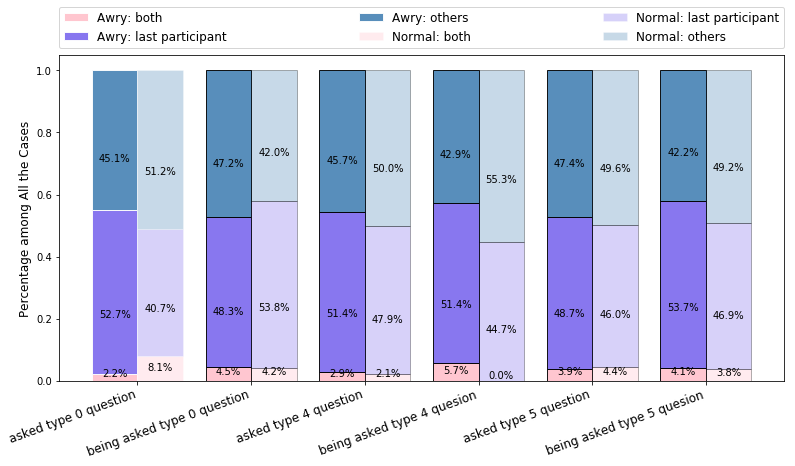

Test 1
question_type0
Average in Ggap:  0.0813008130081
Average of Bgap:  0.021978021978
MannwhitneyuResult(statistic=5264.5, pvalue=0.031609403495801942)


being_asked_question_type0
Average in Ggap:  0.0420168067227
Average of Bgap:  0.0449438202247
MannwhitneyuResult(statistic=5280.0, pvalue=0.46052794168816047)


question_type4
Average in Ggap:  0.0208333333333
Average of Bgap:  0.0285714285714
MannwhitneyuResult(statistic=833.5, pvalue=0.41749984590740413)


being_asked_question_type4
Average in Ggap:  0.0
Average of Bgap:  0.0571428571429
question_type5
Average in Ggap:  0.043795620438
Average of Bgap:  0.0394736842105
MannwhitneyuResult(statistic=10367.0, pvalue=0.42797165075354282)


being_asked_question_type5
Average in Ggap:  0.0384615384615
Average of Bgap:  0.0408163265306
MannwhitneyuResult(statistic=9532.5, pvalue=0.46106335497137552)


Test 2
question_type0 : 2.26663132707e-12
being_asked_question_type0 : 2.78119216546e-09
question_type4 : 7.62939453125e-05
being_asked_q

In [26]:
plot_profiles(question_profile, QUESTION_ASPECTS, num_catergories=3, \
    catergories={'None': 3, 'Attacker': 1, 'Non-Attacker': 2, 'Both':0},\
    cats = ['both', 'last participant', 'others', 'None'], \
    catergory_names = ['asked type 0 question', 'being asked type 0 question', \
                       'asked type 4 question', 'being asked type 4 quesion', \
                       'asked type 5 question', 'being asked type 5 quesion'], \
    conv_label = ['Awry: ', 'Normal: '], \
    experience=-1)

# Top 20 Coefficients of Conversational Features

In [14]:
classifier = svm.LinearSVC(C=1.3)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets = get_features(user_features, documents, ARGS, Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
top_pos, top_neg, num_pos, num_neg = top_coefficients(classifier, feature_names, 20)

/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
top_pos[::-1]

['max_time_gap',
 'avg_len',
 'min_nouns_over_tokens',
 'toxicity_entropy',
 'max_polarity_gap',
 'nouns_over_tokens_entropy',
 'max_toxicity_gap',
 'question_type0',
 'frac. negative_reply',
 'question_type4',
 'max_nouns_over_tokens',
 'min_len',
 'has_content_words_repeat',
 'consecutive_negative',
 'has_policy_intervention',
 'question_type7',
 'user_last_action_has_greetings',
 'last_toxicity_gap',
 'user_last_action_has_thank',
 'user_last_action_has_disagree']

In [9]:
top_neg[::-1]

['max_toxicity',
 'nouns_over_tokens',
 'mean_toxicity_gap',
 'user_last_action_has_consecutive_?or!',
 'has_negative_reply',
 'positive_increase',
 'positive reply to negative',
 "user_last_action_do/don't start",
 'max_len',
 'reciprocity',
 'negative reply to positive',
 'question_to_non_question',
 'user_last_action_verb start',
 'no_comments',
 'time_gap_entropy',
 'max_depth',
 'question_type5',
 'toxicity_raise',
 'reply_entropy',
 'user_last_action_LEXICON_pron_you']

# Attacker Profile Plots

Bad Total:
proportion_of_being_replied 806
proportion_of_utterance_over_all 715
total_length_of_utterance 820
maximum_toxicity 823
age 822
status 502
comments_on_all_talk_pages 733
edits_on_wikipedia_articles 743
history_toxicity 743
pron_you_usage 694
gratitude_usage 237
max_negativity 800
Good Total:
proportion_of_being_replied 846
proportion_of_utterance_over_all 730
total_length_of_utterance 853
maximum_toxicity 856
age 856
status 537
comments_on_all_talk_pages 776
edits_on_wikipedia_articles 765
history_toxicity 786
pron_you_usage 694
gratitude_usage 310
max_negativity 764


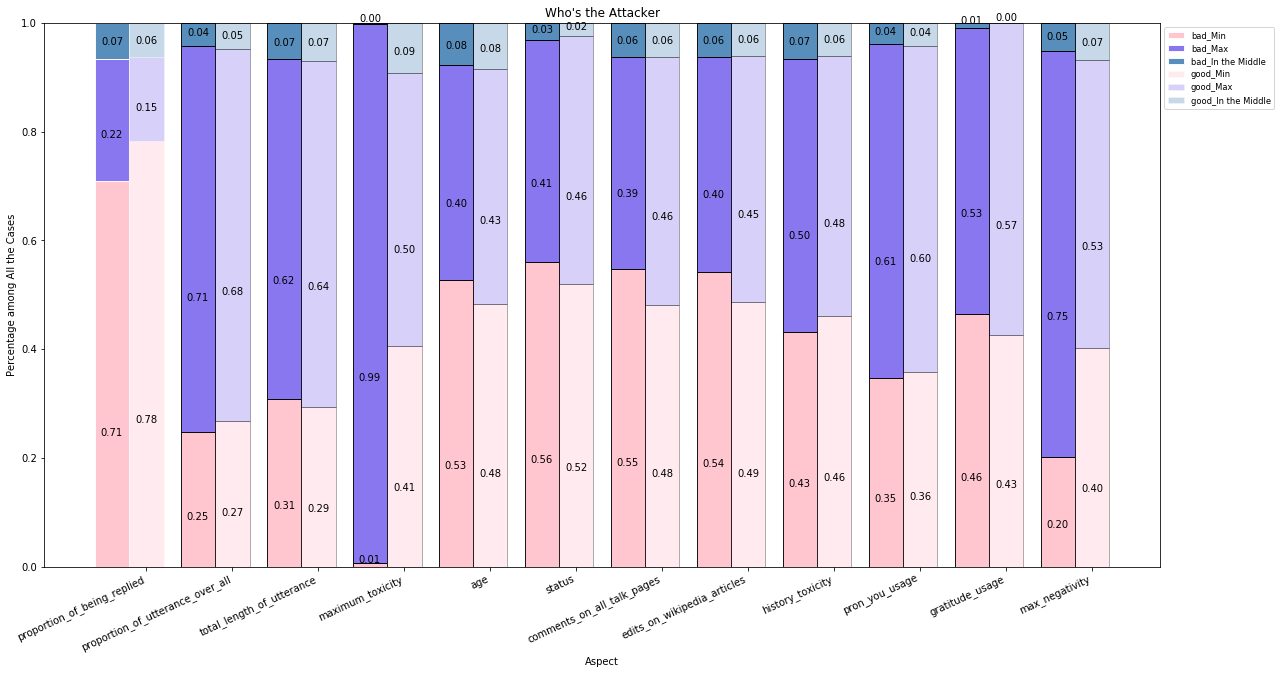

Test 1
proportion_of_being_replied
Average in Ggap:  0.782505910165
Average of Bgap:  0.709677419355
MannwhitneyuResult(statistic=316108.0, pvalue=0.00033410163748432082)


proportion_of_utterance_over_all
Average in Ggap:  0.268493150685
Average of Bgap:  0.247552447552
MannwhitneyuResult(statistic=255510.0, pvalue=0.18165634708075584)


total_length_of_utterance
Average in Ggap:  0.293083235639
Average of Bgap:  0.308536585366
MannwhitneyuResult(statistic=344325.5, pvalue=0.24546859398848125)


maximum_toxicity
Average in Ggap:  0.406542056075
Average of Bgap:  0.00729040097205
MannwhitneyuResult(statistic=211610.0, pvalue=1.1555833367133499e-89)


age
Average in Ggap:  0.482476635514
Average of Bgap:  0.526763990268
MannwhitneyuResult(statistic=336235.0, pvalue=0.034896443887895062)


status
Average in Ggap:  0.519553072626
Average of Bgap:  0.559760956175
MannwhitneyuResult(statistic=129367.5, pvalue=0.097055171073138713)


comments_on_all_talk_pages
Average in Ggap:  0.48195876288

In [5]:
attacker_profile_ASPECTS = ARGS[2]
attacker_plot(all_profiles, attacker_profile_ASPECTS)

Bad Total:
proportion_of_being_replied 806
total_reply_time_gap 800
reply_latency 822
age 822
status 502
edits_on_wikipedia_articles 743
Good Total:
proportion_of_being_replied 846
total_reply_time_gap 823
reply_latency 853
age 856
status 537
edits_on_wikipedia_articles 765


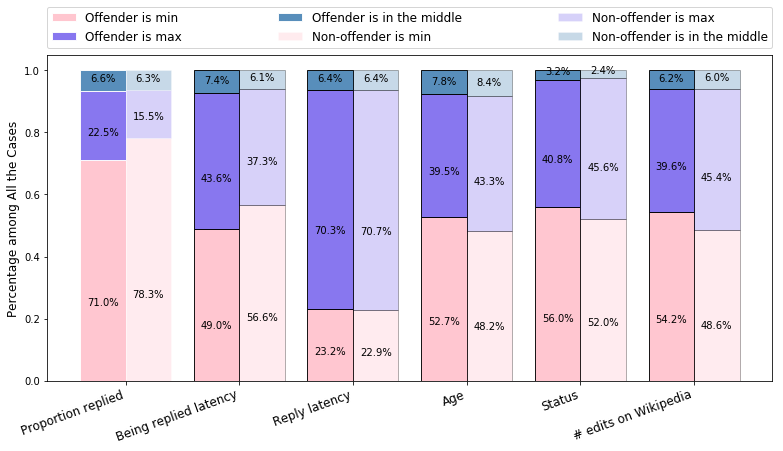

Test 1
proportion_of_being_replied
Average in Ggap:  0.782505910165
Average of Bgap:  0.709677419355
MannwhitneyuResult(statistic=316108.0, pvalue=0.00033410163748432082)


total_reply_time_gap
Average in Ggap:  0.566221142163
Average of Bgap:  0.49
MannwhitneyuResult(statistic=304108.0, pvalue=0.0010545720033721835)


reply_latency
Average in Ggap:  0.228604923798
Average of Bgap:  0.232360097324
MannwhitneyuResult(statistic=349266.5, pvalue=0.42766600555040479)


age
Average in Ggap:  0.482476635514
Average of Bgap:  0.526763990268
MannwhitneyuResult(statistic=336235.0, pvalue=0.034896443887895062)


status
Average in Ggap:  0.519553072626
Average of Bgap:  0.559760956175
MannwhitneyuResult(statistic=129367.5, pvalue=0.097055171073138713)


edits_on_wikipedia_articles
Average in Ggap:  0.486274509804
Average of Bgap:  0.542395693136
MannwhitneyuResult(statistic=268248.0, pvalue=0.014659333527836651)


Test 2
proportion_of_being_replied : 4.75849368781e-48
total_reply_time_gap : 0.122

In [27]:
attacker_profile_ASPECTS = ARGS[2]

plot_profiles(all_profiles, attacker_profile_ASPECTS)